# File Validations

The main objective of this notebook is to verify that all formats tested in the speed test benchmarking contain all of the data held in the original NetCDF file. To test this, we will put the data into an Xarray DataArray, where the same subset of data will be plotted in order to ensure that nothing was lost in the file transformation process.

In [1]:
import dask.dataframe as dd
import dask.array as dsa
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake

In [2]:
def plot(da1):
    da1.plot()
    global da
    del da

## NetCDF

First, the NetCDF format will be tested. This is the original data format and serves as a control file that others will be tested against.

In [4]:
ds = intake.open_netcdf('gs://cloud-data-benchmarks/ETOPO1_Ice_g_gmt4.nc').to_dask()
da = ds.to_array()
lon_vals = da.coords['lon'].values
lat_vals = da.coords['lat'].values

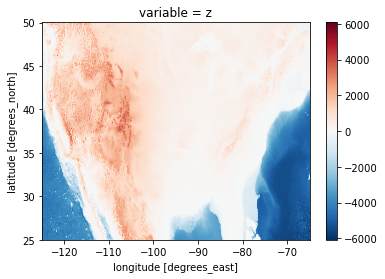

In [4]:
da = da[dict(variable=slice(1), lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)

## CSV

Be warned, running the CSV cells will take a very long time. The output is left here to show that the all of the original data is present, but it is still runable if you wish to test on your own.  

The reason for this has to do with the large amount of duplicate values present in the DataFrame, as well as the long time it takes to convert from a regular DataFrame to a Pivot Table. Creating a pivot table is necessary in order to preserve the grid format that the original NetCDF file contains.

### Single File

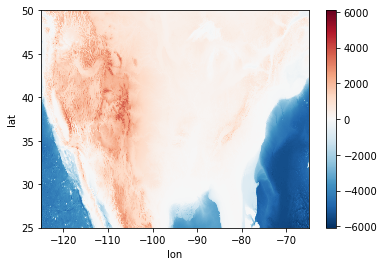

In [10]:
df = dd.read_csv('gs://cloud-data-benchmarks/ETOPO1_Ice_g_gmt4.csv', assume_missing=True, names=['lon', 'lat', 'z'])
df = df.categorize(columns=['lon'])
df_pv = df.pivot_table(index='lat', columns='lon', values='z')
da = xr.DataArray(data=df_pv, dims=['lat', 'lon'], coords=dict(lat=lat_vals, lon=lon_vals))
da = da[dict(lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)
del df

### Multiple Files

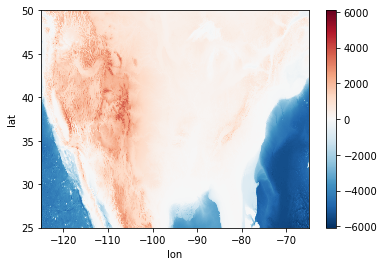

In [5]:
df = dd.read_csv('gs://cloud-data-benchmarks/csvpartitions/*', assume_missing=True, names=['lon', 'lat', 'z'])
df = df.categorize(columns=['lon'])
df_pv = df.pivot_table(index='lat', columns='lon', values='z')
da = xr.DataArray(data=df_pv, dims=['lat', 'lon'], coords=dict(lat=lat_vals, lon=lon_vals))
da = da[dict(lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)
del df

## Parquet

Like the CSV section, this will also take a very long time to run.

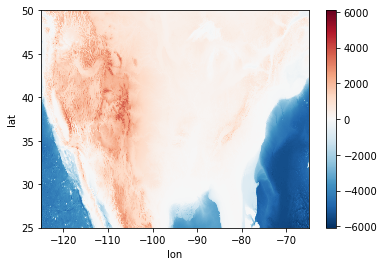

In [6]:
df = dd.read_parquet("gs://cloud-data-benchmarks/parquetpartitions/*")
df = df.categorize(columns=['lon'])
df_pv = df.pivot_table(index='lat', columns='lon', values='z')
da = xr.DataArray(data=df_pv, dims=['lat', 'lon'], coords=dict(lat=lat_vals, lon=lon_vals))
da = da[dict(lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)
del df

## Zarr

### Group

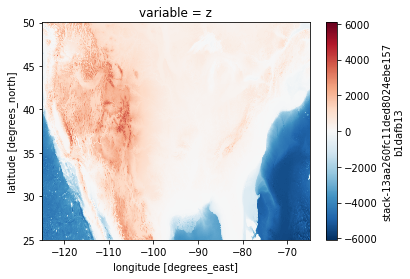

In [5]:
ds = xr.open_zarr(store='gs://cloud-data-benchmarks/ETOPO1_Ice_g_gmt4.zarr', consolidated=True)
da = ds.to_array()
da = da[dict(variable=slice(1), lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)

### Array

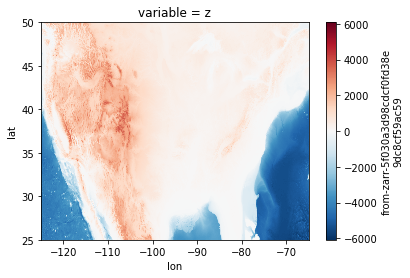

In [6]:
da = dsa.from_zarr('gs://cloud-data-benchmarks/ETOPO1_Ice_g_gmt4.zarray')
da = xr.DataArray(data=da, dims=['variable','lat', 'lon'], coords=dict(variable=['z'], lat=lat_vals, lon=lon_vals))
da = da[dict(variable=slice(1), lat=slice(6900, 8401), lon=slice(3300,6901))]
plot(da)